In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller # adf平稳性检验
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 打印自相关图和偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox # 白噪声检验

from statsmodels.tsa.ar_model import AutoReg # auto regression模型
from sklearn.metrics import mean_squared_error as MSE # 评价指标

import sys
sys.path.append("../../")
from utils import metrics

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 413 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [3]:
# # data是非平稳序列
# data = pd.DataFrame(np.array(range(10)), columns=["capaciy"])
# head = data.iloc[0].item()
# # 一阶差分后data_diff为平稳序列
# data_diff = data.diff().fillna(head)
# # 一阶差分后复原
# data_recovery = data_diff.cumsum().fillna(head)

## CALCE数据集

In [4]:
# 读取容量数据
calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
calce_data = np.load(calce_data_path, allow_pickle=True)
b35 = calce_data[0]
b36 = calce_data[1]
b37 = calce_data[2]
b38 = calce_data[3]

# for i in (b35, b36, b37, b38):
#     plt.plot(i)

(2.430312187253114, 0.9990238682939495, 20, 861, {'1%': -3.4379677736185514, '5%': -2.8649026847264074, '10%': -2.568560548763626}, -5329.27474388581)
(-7.334935720263416, 1.1028600168460899e-10, 19, 861, {'1%': -3.4379677736185514, '5%': -2.8649026847264074, '10%': -2.568560548763626}, -5317.987560057826)
(881, 1)
       lb_stat     lb_pvalue     bp_stat     bp_pvalue
6    38.437720  9.223581e-07   38.295417  9.834350e-07
12   45.504661  8.442439e-06   45.280839  9.223524e-06
24  104.571421  4.938631e-12  102.929382  9.469051e-12


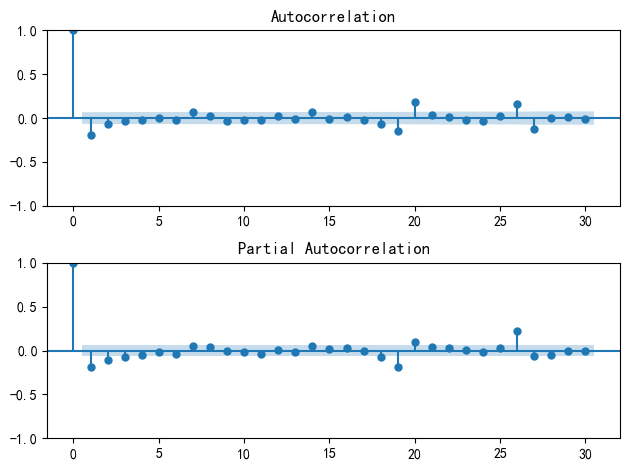

In [5]:
# 任取一块电池的容量退化数据
dataset = b35
dataset = pd.DataFrame(dataset)

# 平稳性检验
print(adfuller(dataset)) # 对训练数据进行平稳性检验，非平稳
# 对训练集进行一阶差分，检查一阶差分后时间序列的平稳性
head = dataset.iloc[0].item()
dataset_diff = dataset.diff().dropna()
print(adfuller(dataset_diff)) # 平稳
# dataset_diff.plot()

# 白噪声检验
# 序列通过平稳性检验后进行白噪声检验，若序列为白噪声，则其取值完全随机，过去行为对未来没有任何影响，分析无意义
print(dataset_diff.shape) # 样本数大于500，使用Q统计量
print(acorr_ljungbox(dataset_diff, lags=[6, 12, 24], boxpierce=True)) # 非白噪声

# 展示自相关图和偏相关图
fig, ax = plt.subplots(2, 1)
plot_acf(dataset_diff, ax[0])
plot_pacf(dataset_diff, ax[1])
plt.tight_layout()
plt.show()

(617,) (265,)
maxE: 0.1702190463735475
mae: 0.009820106458949287
rmse:0.019415178098793187
(655,) (281,)
maxE: 0.0660313091482134
mae: 0.010754855979100109
rmse:0.014229312409040863
(680,) (292,)
maxE: 0.10726718731449009
mae: 0.009932556369623115
rmse:0.014492719548283002
(697,) (299,)
maxE: 0.12231958697683121
mae: 0.011005512863111603
rmse:0.016312021203739265


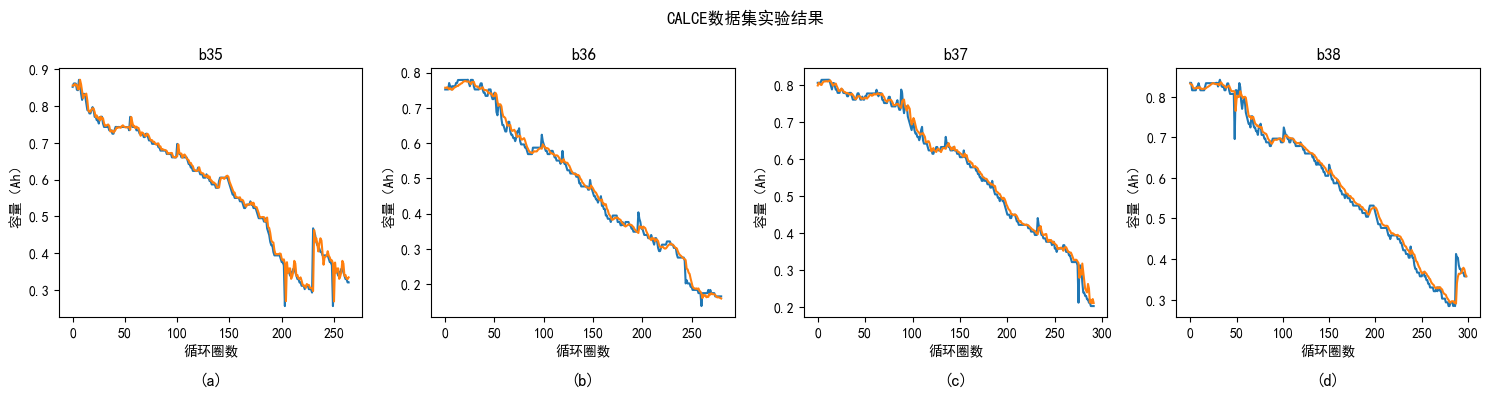

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

fig.suptitle("CALCE数据集实验结果")

for idx, dataset in enumerate((b35, b36, b37, b38)):
    
    # dataset = b35
    train_len = int(len(dataset) * 0.7)
    # dataset = dataset[0:train_len].values
    # test_dataset = dataset[train_len:].values
    train_dataset = dataset[0: train_len]
    test_dataset = dataset[train_len: ]
    print(train_dataset.shape, test_dataset.shape)

    # 建模
    p = 16
    model = AutoReg(train_dataset, lags=p)
    model_fit = model.fit()
    params = model_fit.params
    # print(params)

    # 预测
    history = train_dataset[-p:]
    history = np.hstack(history).tolist()
    pred = []
    for t in range(len(test_dataset)):
        y_hat = params[0] # cotest_datasetnst
        for i in range(p):
            y_hat += params[i + 1] * history[-1 - i]
        pred.append(y_hat)
        history.append(test_dataset[t])

    ax[idx].plot(test_dataset)
    ax[idx].plot(pred)
    ax[idx].set_title(battery_names[idx])
    ax[idx].set_xlabel("循环圈数")
    ax[idx].set_ylabel("容量（Ah）")

    ax[idx].annotate(
            f"({chr(97+idx)})",
            xy=(0.5, -0.25),
            fontsize=12,
            ha="center",
            va="center",
            xycoords="axes fraction",
        )

    plt.tight_layout()
    # plt.show()

    maxE, mae, rmse = metrics.evaluation(test_dataset, pred)
    print(f"maxE: {maxE}\nmae: {mae}\nrmse:{rmse}")

## NASA数据集

In [7]:
nasa_data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
nasa_data = np.load(nasa_data_path, allow_pickle=True)
b05 = nasa_data[0]
b06 = nasa_data[1]
b07 = nasa_data[2]
b18 = nasa_data[3]

# for i in (b05, b06, b07, b18):
#     plt.plot(i)

(-0.5256846711019805, 0.8869061026357288, 2, 165, {'1%': -3.470616369591229, '5%': -2.8792214018977655, '10%': -2.57619681359045}, -882.8914533546758)
(-10.831429699417459, 1.7041928511248134e-19, 1, 165, {'1%': -3.470616369591229, '5%': -2.8792214018977655, '10%': -2.57619681359045}, -877.7359475744158)
(167, 1)


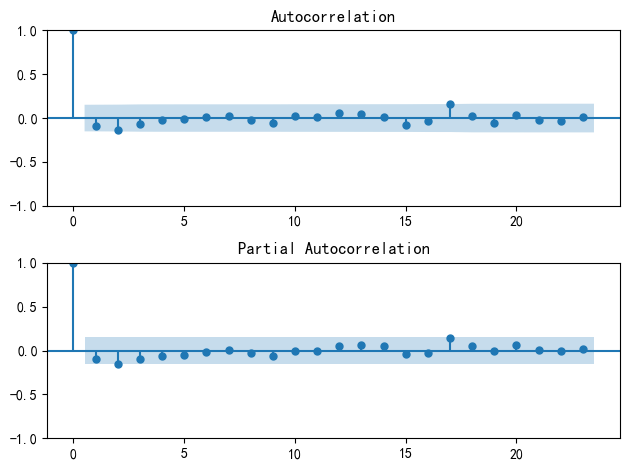

In [8]:
# 任取一块电池的容量退化数据
dataset = b05
dataset = pd.DataFrame(dataset)

# 平稳性检验
print(adfuller(dataset)) # 对训练数据进行平稳性检验，非平稳
# 对训练集进行一阶差分，检查一阶差分后时间序列的平稳性
head = dataset.iloc[0].item()
dataset_diff = dataset.diff().dropna()
print(adfuller(dataset_diff)) # 平稳
# dataset_diff.plot()

# 白噪声检验
# 序列通过平稳性检验后进行白噪声检验，若序列为白噪声，则其取值完全随机，过去行为对未来没有任何影响，分析无意义
print(dataset_diff.shape) # 样本数大于500，使用Q统计量
acorr_ljungbox(dataset_diff, lags=[6, 12, 24], boxpierce=True) # 非白噪声

# 展示自相关图和偏相关图
fig, ax = plt.subplots(2, 1)
plot_acf(dataset_diff, ax[0])
plot_pacf(dataset_diff, ax[1])
plt.tight_layout()
plt.show()

(117,) (51,)
maxE: 0.047775878838863806
mae: 0.007694922948177991
rmse:0.012293805953059452
(117,) (51,)
maxE: 0.03998869667094129
mae: 0.007894527417410493
rmse:0.0117200130212321
(117,) (51,)
maxE: 0.03423330586568585
mae: 0.0053738872773826185
rmse:0.009433239111317611
(92,) (40,)
maxE: 0.0940552711055469
mae: 0.011033736504822627
rmse:0.019982606791794175


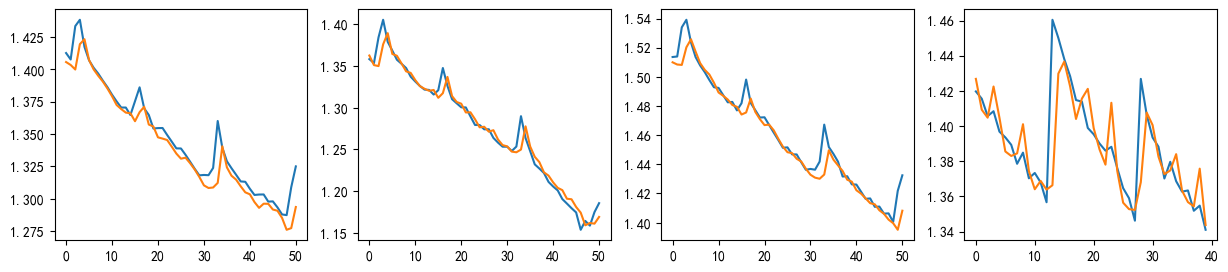

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for idx, dataset in enumerate((b05, b06, b07, b18)):
    
    train_len = int(len(dataset) * 0.7)
    # dataset = dataset[0:train_len].values
    # test_dataset = dataset[train_len:].values
    train_dataset = dataset[0: train_len]
    test_dataset = dataset[train_len: ]
    print(train_dataset.shape, test_dataset.shape)

    # 建模
    p = 16
    model = AutoReg(train_dataset, lags=p)
    model_fit = model.fit()
    params = model_fit.params
    # print(params)

    # 预测
    history = train_dataset[-p:]
    history = np.hstack(history).tolist()
    pred = []
    for t in range(len(test_dataset)):
        y_hat = params[0] # cotest_datasetnst
        for i in range(p):
            y_hat += params[i + 1] * history[-1 - i]
        pred.append(y_hat)
        history.append(test_dataset[t])

    ax[idx].plot(test_dataset)
    ax[idx].plot(pred)

    maxE, mae, rmse = metrics.evaluation(test_dataset, pred)
    print(f"maxE: {maxE}\nmae: {mae}\nrmse:{rmse}")